# Human Action Recognition (HAR) with lightweight NNs 

The dataset for this projec can be found <a href='https://www.csc.kth.se/cvap/actions/'>here.</a> I personally downloaded the dataset manually then extracted and put it into folder via code. If you want you can use `requests` of some other similar library to do everything via code. In that case you might need the links for the zip file for each individual action.


*The current video database containing six types of human actions (walking, jogging, running, boxing, hand waving and hand clapping) performed several times by 25 subjects in four different scenarios: outdoors s1, outdoors with scale variation s2, outdoors with different clothes s3 and indoors s4 as illustrated below. Currently the database contains 2391 sequences. All sequences were taken over homogeneous backgrounds with a static camera with 25fps frame rate. The sequences were downsampled to the spatial resolution of 160x120 pixels and have a length of four seconds in average.*

The above paragraph taken from the <a href='https://www.csc.kth.se/cvap/actions/'>dataset source</a> succinctly  describes the dataset that we will working on.  

In [ ]:
import os 
import zipfile
from pathlib import Path

In [9]:
# Set the path to the data folder and image folder 
data_path = Path('Data')
video_path = data_path / 'KTH_Actions'

In [ ]:
# If the image folder exists then skip the extraction and creation of the data 
# (NOTE this does not check whether files in the dir exists only whether the dir exists)
# If the image folder doesn't exist, download it and prepare it... 

if video_path.is_dir():
    print(f"{video_path} directory exists.")
else:
    print(f"Did not find {video_path} directory, creating one...")
    video_path.mkdir(parents=True, exist_ok=True)

    zip_list = list(data_path.glob('*.zip'))
    print(zip_list)
    
    # Unzip HAR data
    for item in zip_list:

    
        with zipfile.ZipFile(item, "r") as zip_ref:
            print(f"Unzipping {item.stem}") 
            zip_ref.extractall(video_path)

    # Remove zip file after extracting
    # os.remove(item)





Data\KTH_Actions directory exists.


In [ ]:
# Put the extracted video files into train/test folder with subfolders in each for all 6 categories

import os
import re
import shutil
from pathlib import Path
from sklearn.model_selection import train_test_split

# Root path after extraction
data_path = Path('Data')
video_path = data_path / 'KTH_Actions'

# Where to put organized data
train_dir = video_path / 'train'
test_dir = video_path / 'test'

# Create directories
for d in [train_dir, test_dir]:
    d.mkdir(parents=True, exist_ok=True)

# Get all video files recursively
video_files = list(video_path.rglob("*.avi"))

print(f"Found {len(video_files)} video files.")

# Regular expression to extract person ID and action
pattern = re.compile(r"person(\d{2})_([a-zA-Z]+)_d\d+_uncomp")

# Parse filenames
data = []
for vf in video_files:
    match = pattern.search(vf.stem)
    if match:
        person_id = int(match.group(1))
        action = match.group(2)
        data.append((vf, person_id, action))

print(f"Parsed {len(data)} valid filenames.")

# -----------------------------
# Define train/test split by person
# -----------------------------

# KTH has 25 subjects (person01–person25)
# Example: use 1–16 for training, 17–25 for testing (actor-based split)
train_persons = set(range(1, 17))
test_persons  = set(range(17, 26))

# -----------------------------
# Move files into organized structure
# -----------------------------

for vf, pid, action in data:
    if pid in train_persons:
        dest_dir = train_dir / action
    else:
        dest_dir = test_dir / action
    dest_dir.mkdir(parents=True, exist_ok=True)
    
    dest_file = dest_dir / vf.name
    if not dest_file.exists():  # avoid overwriting
        shutil.move(str(vf), str(dest_file))

print("✅ Dataset organized into train/test folders successfully!")


Now that we have the data lets start preparing the data for our model.

In [11]:
# Let's create a folder to keep all of our custom functions that we may reuse
util_path = Path('utils')
util_path.mkdir(parents=True, exist_ok=True)


In [1]:
%%writefile 'utils/data_setup.py'

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
import os
from pathlib import Path
from glob import glob
import random

class VideoDataset_1(Dataset):
    def __init__(self, root_dir, transform=None, frames_per_clip=16, frame_skip=2):
        """
        root_dir: path to dataset split (e.g., Data/ETH_Actions/train)
        transform: torchvision transforms to apply to each frame
        frames_per_clip: number of frames to sample per video
        frame_skip: skip factor to spread frames across the video
        """
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.frames_per_clip = frames_per_clip
        self.frame_skip = frame_skip

        # Get all videos and labels
        self.classes = sorted([d.name for d in self.root_dir.iterdir() if d.is_dir()])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        self.video_paths = []
        for cls in self.classes:
            for vid in glob(str(self.root_dir / cls / "*.avi")):
                self.video_paths.append((vid, cls))

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path, label_name = self.video_paths[idx]
        label = self.class_to_idx[label_name]
        frames = self._load_video(video_path)

        # Convert to PIL for transforms
        if self.transform:
            from torchvision.transforms.functional import to_pil_image
            frames = [self.transform(to_pil_image(f)) for f in frames]

        frames = torch.stack(frames)  # (T, C, H, W)
        frames = frames.mean(dim=0)    # (C, H, W) ← average frames

        return frames, label

        
        
    def _load_video(self, path):
        cap = cv2.VideoCapture(path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_indices = list(range(0, total_frames, self.frame_skip))
        if len(frame_indices) > self.frames_per_clip:
            frame_indices = random.sample(frame_indices, self.frames_per_clip)

        frames = []
        for i in sorted(frame_indices):
            cap.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, frame = cap.read()
            if not ret:
                continue
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = torch.from_numpy(frame).permute(2, 0, 1).float() / 255.0
            frames.append(frame)
        cap.release()

        # Pad if fewer frames than expected
        while len(frames) < self.frames_per_clip:
            frames.append(frames[-1])
        return frames


class VideoDataset_2(Dataset):
    def __init__(self, root_dir, transform=None, frames_per_clip=16, frame_skip=2):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.frames_per_clip = frames_per_clip
        self.frame_skip = frame_skip

        self.classes = sorted([d.name for d in self.root_dir.iterdir() if d.is_dir()])
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        self.video_paths = []
        for cls in self.classes:
            for vid in glob(str(self.root_dir / cls / "*.avi")):
                self.video_paths.append((vid, cls))

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path, label_name = self.video_paths[idx]
        label = self.class_to_idx[label_name]
        frames = self._load_video(video_path)

        processed_frames = []
        for f in frames:
            # Convert to grayscale [H, W]
            if f.ndim == 3:
                f = cv2.cvtColor(f, cv2.COLOR_BGR2GRAY)
            # Convert to tensor [1, H, W]
            f = torch.from_numpy(f).unsqueeze(0).float() / 255.0
            if self.transform:
                from torchvision.transforms.functional import to_pil_image
                f = self.transform(to_pil_image(f))
            processed_frames.append(f)

        frames_tensor = torch.stack(processed_frames)  # [T, 1, H, W]
        return frames_tensor, label

    def _load_video(self, path):
        cap = cv2.VideoCapture(path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_indices = list(range(0, total_frames, self.frame_skip))
        if len(frame_indices) > self.frames_per_clip:
            frame_indices = random.sample(frame_indices, self.frames_per_clip)

        frames = []
        for i in sorted(frame_indices):
            cap.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, frame = cap.read()
            if not ret:
                continue
            frames.append(frame)
        cap.release()

        # Pad if fewer frames than expected
        while len(frames) < self.frames_per_clip:
            frames.append(frames[-1])
        return frames



class VideoDataset_3(Dataset):
    def __init__(self, root_dir, transform=None, frames_per_clip=16, frame_skip=1):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.frames_per_clip = frames_per_clip
        self.frame_skip = frame_skip

        # Classes and mapping
        self.classes = sorted([d.name for d in self.root_dir.iterdir() if d.is_dir()])
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        # Gather video paths
        self.video_paths = []
        for cls in self.classes:
            for vid in glob(str(self.root_dir / cls / "*.avi")):
                self.video_paths.append((vid, cls))

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path, label_name = self.video_paths[idx]
        label = self.class_to_idx[label_name]

        frames = self._load_video(video_path)
        processed_frames = []

        for f in frames:
            if f.ndim == 2:  # H x W grayscale
                f = torch.from_numpy(f).unsqueeze(0).float() / 255.0
            else:
                f = torch.from_numpy(f).permute(2,0,1).float() / 255.0  # unlikely for KTH

            if self.transform:
                from torchvision.transforms.functional import to_pil_image
                f = self.transform(to_pil_image(f))
            processed_frames.append(f)

        frames_tensor = torch.stack(processed_frames)  # [T, 1, H, W]
        return frames_tensor, label

    def _load_video(self, path):
        cap = cv2.VideoCapture(path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_indices = list(range(0, total_frames, self.frame_skip))

        # Sample frames if longer than frames_per_clip
        if len(frame_indices) > self.frames_per_clip:
            frame_indices = sorted(random.sample(frame_indices, self.frames_per_clip))

        frames = []
        for i in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, frame = cap.read()
            if not ret:
                continue
            # ETH is grayscale
            if len(frame.shape) == 3 and frame.shape[2] > 1:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frames.append(frame)

        cap.release()

        # Pad if fewer frames
        while len(frames) < self.frames_per_clip:
            frames.append(frames[-1])
        return frames



class VideoDataset_4(Dataset):
    def __init__(self, root_dir, transform=None, frames_per_clip=16, frame_skip=1):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.frames_per_clip = frames_per_clip
        self.frame_skip = frame_skip

        # Classes and mapping
        self.classes = sorted([d.name for d in self.root_dir.iterdir() if d.is_dir()])
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        # Gather video paths
        self.video_paths = []
        for cls in self.classes:
            for vid in glob(str(self.root_dir / cls / "*.avi")):
                self.video_paths.append((vid, cls))

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path, label_name = self.video_paths[idx]
        label = self.class_to_idx[label_name]

        frames = self._load_video(video_path)
        processed_frames = []

        for f in frames:
            if f.ndim == 2:
                f = torch.from_numpy(f).unsqueeze(0).float() / 255.0
            else:
                f = torch.from_numpy(f).permute(2,0,1).float() / 255.0

            if self.transform:
                from torchvision.transforms.functional import to_pil_image
                f = self.transform(to_pil_image(f))
            processed_frames.append(f)

        frames_tensor = torch.stack(processed_frames)  # [T, 1, H, W]

        # Return dict for compatibility with training loop
        return {
            "frames": frames_tensor, 
            "labels": torch.tensor(label, dtype=torch.long)
        }


    def _load_video(self, path):
        cap = cv2.VideoCapture(path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_indices = list(range(0, total_frames, self.frame_skip))

        # Sample frames if longer than frames_per_clip
        if len(frame_indices) > self.frames_per_clip:
            frame_indices = sorted(random.sample(frame_indices, self.frames_per_clip))

        frames = []
        for i in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, frame = cap.read()
            if not ret:
                continue
            # KTH is grayscale
            if len(frame.shape) == 3 and frame.shape[2] > 1:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frames.append(frame)

        cap.release()

        # Pad if fewer frames
        while len(frames) < self.frames_per_clip:
            frames.append(frames[-1])
        return frames





Overwriting utils/data_setup.py


With the above code you should find a data_setup.py file in your newly created utils folder. 

**NOTE** I will be adding new python classes to this function for the slight variations in how the video file will be handled in each iteration. Ideally once my model and preprocesses meet my objectives it should only hold the final classes and functions to improve clarity and reduce clutter.

In [11]:
%%writefile 'utils/engine.py'

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models as M
from pathlib import Path
from glob import glob
import cv2
import random
from tqdm.auto import tqdm
import torch.nn.functional as F

# Seed helper
def set_seeds(seed: int = 42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def train_step(model, dataloader, loss_fn, optimizer, device):
    model.train()
    train_loss, train_acc = 0, 0
    for X, y in dataloader:
        # Take middle frame [B, T, 1, H, W] → [B, 1, H, W]
        mid_idx = X.shape[1] // 2
        X = X[:, mid_idx, :, :, :].to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += (y_pred.argmax(dim=1) == y).float().mean().item()

    return train_loss / len(dataloader), train_acc / len(dataloader)


def test_step(model, dataloader, loss_fn, device):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for X, y in dataloader:
            mid_idx = X.shape[1] // 2
            X = X[:, mid_idx, :, :, :].to(device)
            y = y.to(device)

            y_pred = model(X)
            loss = loss_fn(y_pred, y)

            test_loss += loss.item()
            test_acc += (y_pred.argmax(dim=1) == y).float().mean().item()

    return test_loss / len(dataloader), test_acc / len(dataloader)

def train_model(model, train_loader, test_loader, optimizer, loss_fn, epochs, device):
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, train_loader, loss_fn, optimizer, device)
        test_loss, test_acc = test_step(model, test_loader, loss_fn, device)

        print(f"Epoch {epoch+1} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results


### For multi-frame per video  


def train_step_2(model, dataloader, loss_fn, optimizer, device):
    model.train()
    total_loss, total_acc = 0, 0

    for X, y in dataloader:
        # X: [B, T, C, H, W] — frames per video
        B, T, C, H, W = X.shape
        X = X.view(B * T, C, H, W).to(device)  # merge batch & time

        y = y.to(device)

        # Forward through CNN in batch
        frame_logits = model(X)               # [B*T, num_classes]
        frame_logits = frame_logits.view(B, T, -1)

        # ✅ Temporal softmax smoothing (per video)
        frame_probs = F.softmax(frame_logits, dim=-1)
        avg_probs = frame_probs.mean(dim=1)   # [B, num_classes]

        # Compute loss on averaged probs
        loss = loss_fn(avg_probs, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += (avg_probs.argmax(1) == y).float().mean().item()

    return total_loss / len(dataloader), total_acc / len(dataloader)


def test_step_2(model, dataloader, loss_fn, device):
    model.eval()
    total_loss, total_acc = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            B, T, C, H, W = X.shape
            X = X.view(B * T, C, H, W).to(device)
            y = y.to(device)

            frame_logits = model(X)
            frame_logits = frame_logits.view(B, T, -1)

            frame_probs = F.softmax(frame_logits, dim=-1)
            avg_probs = frame_probs.mean(dim=1)

            loss = loss_fn(avg_probs, y)
            total_loss += loss.item()
            total_acc += (avg_probs.argmax(1) == y).float().mean().item()

    return total_loss / len(dataloader), total_acc / len(dataloader)


def train_2(model, train_loader, test_loader, optimizer, loss_fn, epochs, device):
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    for epoch in tqdm(range(epochs)):
        tr_loss, tr_acc = train_step_2(model, train_loader, loss_fn, optimizer, device)
        te_loss, te_acc = test_step_2(model, test_loader, loss_fn, device)
        print(f"Epoch {epoch+1} | Train Loss: {tr_loss:.4f}, Train Acc: {tr_acc:.4f} | "
              f"Test Loss: {te_loss:.4f}, Test Acc: {te_acc:.4f}")
        results["train_loss"].append(tr_loss)
        results["train_acc"].append(tr_acc)
        results["test_loss"].append(te_loss)
        results["test_acc"].append(te_acc)
    return results



## EFFICIENT_NET BACKBONE WITH GRU

# ---------------------------
# Train step 
# ---------------------------
def train_step_3(model, backbone, dataloader, optimizer, loss_fn, device):
    model.train()
    backbone.eval()  # backbone frozen
    total_loss, total_acc = 0, 0

    loop = tqdm(dataloader, desc="Training", leave=False)
    for batch in loop:
        X = batch["frames"].to(device)
        y = batch["labels"].to(device)

        with torch.no_grad():
            embeddings = backbone(X)  # [B, T, 1280]

        logits = model(embeddings)
        loss = loss_fn(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += (logits.argmax(1) == y).float().mean().item()

        loop.set_postfix({
            "loss": f"{loss.item():.4f}",
            "acc": f"{(logits.argmax(1) == y).float().mean().item():.4f}"
        })

    return total_loss / len(dataloader), total_acc / len(dataloader)


# ---------------------------
# Test step 
# ---------------------------
def test_step_3(model, backbone, dataloader, loss_fn, device):
    model.eval()
    backbone.eval()
    total_loss, total_acc = 0, 0

    loop = tqdm(dataloader, desc="Testing ", leave=False)
    with torch.no_grad():
        for batch in loop:
            X = batch["frames"].to(device)
            y = batch["labels"].to(device)
            embeddings = backbone(X)
            logits = model(embeddings)
            loss = loss_fn(logits, y)

            total_loss += loss.item()
            total_acc += (logits.argmax(1) == y).float().mean().item()

            loop.set_postfix({
                "loss": f"{loss.item():.4f}",
                "acc": f"{(logits.argmax(1) == y).float().mean().item():.4f}"
            })

    return total_loss / len(dataloader), total_acc / len(dataloader)


# ---------------------------
# Main training loop 
# ---------------------------
def train_model_3(backbone, temporal_model, train_loader, test_loader, optimizer, loss_fn, device, epochs=20):
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    epoch_loop = tqdm(range(epochs), desc="Epochs", unit="epoch")
    for epoch in epoch_loop:
        tr_loss, tr_acc = train_step_3(temporal_model, backbone, train_loader, optimizer, loss_fn, device)
        te_loss, te_acc = test_step_3(temporal_model, backbone, test_loader, loss_fn, device)

        results["train_loss"].append(tr_loss)
        results["train_acc"].append(tr_acc)
        results["test_loss"].append(te_loss)
        results["test_acc"].append(te_acc)

        epoch_loop.set_postfix({
            "train_acc": f"{tr_acc:.4f}",
            "test_acc": f"{te_acc:.4f}",
            "train_loss": f"{tr_loss:.4f}",
            "test_loss": f"{te_loss:.4f}"
        })

    return results



Overwriting utils/engine.py


In [2]:
%%writefile 'utils/viz.py'


import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
import cv2
import numpy as np
from pathlib import Path
from PIL import Image
from torchmetrics.classification import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
import torch.nn.functional as F


# Set deivce
device = 'cuda' if torch.cuda.is_available() else 'cpu'


# ✅ Define preprocessing (convert to PIL first)
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

def load_video_frames(video_path, num_frames=16, frame_skip=2):
    """Returns sampled frames from a video as transformed tensors (PIL -> Tensor)."""
    cap = cv2.VideoCapture(str(video_path))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
    frames = []
    for i in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            continue
        # Convert to grayscale (ETH/KTH)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = Image.fromarray(frame)  # ✅ Convert to PIL Image
        frame = transform(frame)        # ✅ Apply transforms safely
        frames.append(frame)
    cap.release()
    return torch.stack(frames)  # shape (T, 1, 224, 224)



def show_middle_frame_batch(dataloader, max_images=16):
    """
    Visualize the middle-frame inputs that are fed to the model.
    Assumes dataloader yields: X [B, T, C, H, W], y [B]
    """
    # Grab one batch
    X, y = next(iter(dataloader))
    
    B, T, C, H, W = X.shape
    mid_idx = T // 2

    # Get the middle frames
    mid_frames = X[:, mid_idx]   # [B, C, H, W]

    # Limit number of images
    num_show = min(B, max_images)

    cols = 4
    rows = (num_show + cols - 1) // cols

    plt.figure(figsize=(12, 3 * rows))

    for i in range(num_show):
        frame = mid_frames[i].squeeze(0).numpy()   # From [1,H,W] to [H,W]

        plt.subplot(rows, cols, i + 1)
        plt.imshow(frame, cmap="gray")
        plt.title(f"Label: {y[i].item()}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()




def plot_confusion_matrix_avg_over_frames(data_loader, model, train_dataset):
    
    """
    Computes and plots the confusion matrix by averaging per-frame predictions
    for each video. Suitable for models without explicit temporal heads.
    """

    # Ensure model is in eval mode
    model.eval()

    # Collect all predictions and labels
    all_preds = []
    all_labels = []

    with torch.inference_mode():
        for X, y in data_loader:
            # X shape: [B, T, C, H, W]
            B, T, C, H, W = X.shape

            # Flatten frames into batch for prediction
            X_flat = X.view(B * T, C, H, W).to(device)

            # Get frame-level logits
            frame_logits = model(X_flat)  # [B*T, num_classes]

            # Reshape back to [B, T, num_classes]
            frame_logits = frame_logits.view(B, T, -1)

            # Convert to probabilities
            frame_probs = F.softmax(frame_logits, dim=-1)

            # Average probabilities over frames
            avg_probs = frame_probs.mean(dim=1)  # [B, num_classes]

            # Predicted class per video
            preds = avg_probs.argmax(dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())

    # Concatenate all predictions and labels
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # Compute confusion matrix
    num_classes = len(train_dataset.classes)
    confmat = ConfusionMatrix(task="multiclass", num_classes=num_classes)
    cm = confmat(all_preds, all_labels).numpy()

    # Plot using mlxtend
    fig, ax = plot_confusion_matrix(
        conf_mat=cm,
        class_names=train_dataset.classes,
        figsize=(8, 6),
        show_normed=True,
        colorbar=True
    )

    plt.title("Confusion Matrix on Test Set (Avg over frames)")
    plt.show()


def plot_confusion_matrix_temporal_GRU(train_dataset,backbone,temporal_model,data_loader):

    '''Plots a confusion matrix for the last model Effnet_backbone with temporal GRU'''

    
    


    backbone.eval()
    temporal_model.eval()
    all_preds = []
    all_labels = []

    with torch.inference_mode():
        for batch in data_loader:
            X = batch["frames"].to(device)  # [B, T, C, H, W]
            y = batch["labels"].to(device)  # [B]

            B, T, C, H, W = X.shape
            

            # Backbone → embeddings
            embeddings = backbone(X)
            logits = temporal_model(embeddings)  # [B, num_classes]

            all_preds.append(logits.argmax(dim=1).cpu())
            all_labels.append(y.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # Compute confusion matrix
    num_classes = len(train_dataset.classes)
    confmat = ConfusionMatrix(task="multiclass", num_classes=num_classes)
    cm = confmat(all_preds, all_labels).numpy()

    # Plot
    fig, ax = plot_confusion_matrix(
        conf_mat=cm,
        class_names=train_dataset.classes,
        figsize=(8, 6),
        show_normed=True,
        colorbar=True
    )
    plt.title("Confusion Matrix (Test Set)")
    plt.show()



Writing utils/viz.py


In [14]:
from torchvision.models import EfficientNet_B0_Weights

weights = EfficientNet_B0_Weights.DEFAULT
video_transform = weights.transforms()

video_transform


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

These are the transforms that were applied to original dataset that the `EfficientNet_B0` model was trained on.

In [18]:
# Lets now finally prepare the dataset and dataloader for training our model.
from utils.data_setup import VideoDataset_1
from torch.utils.data import DataLoader

train_dir = "Data/KTH_Actions/train"
test_dir = "Data/KTH_Actions/test"

train_dataset = VideoDataset_1(train_dir, transform=video_transform)
test_dataset = VideoDataset_1(test_dir, transform=video_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)


In [20]:
# lets see the shapes and lables of the data in the dataloader
for videos, labels in train_loader:
    print(videos.shape)  # [B, T, C, H, W]
    print(labels)
    break


torch.Size([16, 3, 224, 224])
tensor([0, 1, 2, 5, 1, 0, 4, 1, 4, 3, 0, 2, 5, 2, 4, 0])


In [22]:
# Setup device agnostic code so that you are utilizing the hardware available to you
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [23]:
import torch
from torch import nn
from torchvision import models as M
from helper_functions import set_seeds

model  = M.efficientnet_b0(weights=M.EfficientNet_B0_Weights.DEFAULT)


# Freeze all base layers by setting requires_grad attribute to False
for param in model.features.parameters():
    param.requires_grad = False
    
# Since we're creating a new layer with random weights (torch.nn.Linear), 
# let's set the seeds 
# This function is taken from the helper_functions file used in 'https://www.learnpytorch.io/' course 
set_seeds() 

# Update the classifier head to suit our problem
model.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True), #the dropout randomly 'drops out'/zeros some of the neurons in the layer, this often helps in reducing overfitting. 
    nn.Linear(in_features=1280, 
              out_features=len(train_dataset.classes),
              bias=True).to(device))



In [24]:
from torchinfo import summary

#  Get a summary of the model 
# '''
summary(model, 
         input_size=(4, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
         verbose=0,
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"]
 )
# '''

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [4, 3, 224, 224]     [4, 6]               --                   Partial
├─Sequential (features)                                      [4, 3, 224, 224]     [4, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [4, 3, 224, 224]     [4, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [4, 3, 224, 224]     [4, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [4, 32, 112, 112]    [4, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [4, 32, 112, 112]    [4, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [4, 32, 112, 112]    [4, 1

In [25]:
# Set the Loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [27]:
import engine
set_seeds()
results = engine.train(model=model,
                train_dataloader=train_loader,
                test_dataloader=test_loader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.7928 | train_acc: 0.2188 | test_loss: 1.7756 | test_acc: 0.2054
Epoch: 2 | train_loss: 1.7250 | train_acc: 0.2821 | test_loss: 1.7242 | test_acc: 0.2455
Epoch: 3 | train_loss: 1.6704 | train_acc: 0.2849 | test_loss: 1.6416 | test_acc: 0.3080
Epoch: 4 | train_loss: 1.6175 | train_acc: 0.3526 | test_loss: 1.5869 | test_acc: 0.2991
Epoch: 5 | train_loss: 1.5857 | train_acc: 0.3705 | test_loss: 1.5511 | test_acc: 0.3839


In [ ]:
# code for saving the model after training

from going_modular import utils 

model_path = Path('model')
model_path.mkdir(parents=True,exist_ok=True)


utils.save_model(model=model,target_dir=model_path,model_name='your_model_name.pth')

Seems like our model performed rather poorly. Let's look at the data input to see whether we can get a clue as to what happened.

In [28]:
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
import cv2
import numpy as np
from pathlib import Path
from PIL import Image

# ✅ Define preprocessing (convert to PIL first)
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

def load_video_frames(video_path, num_frames=16, frame_skip=2):
    cap = cv2.VideoCapture(str(video_path))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
    frames = []
    for i in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            continue
        # Convert to grayscale (ETH/KTH)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = Image.fromarray(frame)  # ✅ Convert to PIL Image
        frame = transform(frame)        # ✅ Apply transforms safely
        frames.append(frame)
    cap.release()
    return torch.stack(frames)  # shape (T, 1, 224, 224)

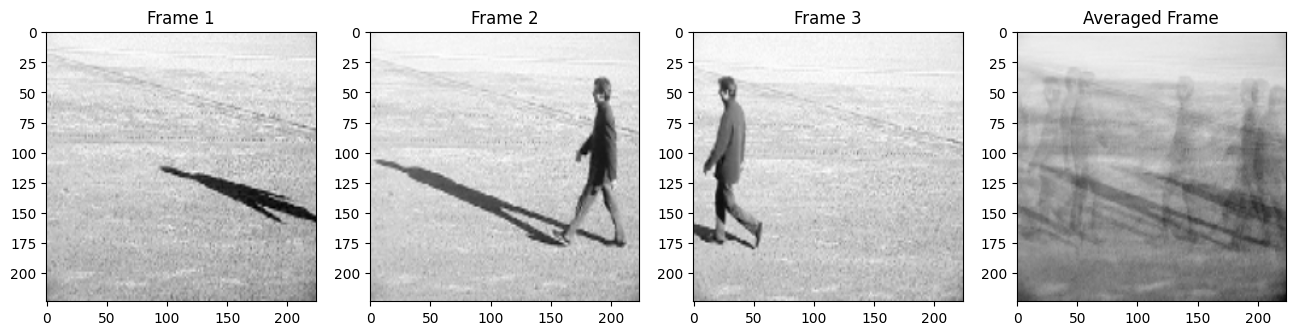

In [29]:
# --- Visualization ---
video_path = Path(train_dir) / 'walking'/ 'person14_walking_d1_uncomp.avi'
frames = load_video_frames(video_path)

avg_frame = frames.mean(dim=0).squeeze().numpy()

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i in range(3):
    axs[i].imshow(frames[i].squeeze(), cmap='gray')
    axs[i].set_title(f"Frame {i+1}")
axs[3].imshow(avg_frame, cmap='gray')
axs[3].set_title("Averaged Frame")
plt.show()

So, now we see the issue, what happened was the model was fed temporally distorted data in the form of average frames and it's barely understandable what's happening in the picture. 

Even to a human observer it looks like ghoslty apparition is in the picture. So then the simple naive approach to avg temporal data in the hope that imortant information is retained is a bad idea for this case. 

However, this would perhaps be useful in cases where we need to recognise/classify scenes where the subject does not vary that much with respect to time. Example classifying scenes from video ex-hilly-areas, muddy-areas, etc. Or for classifying anomalies from video feeds.





Next let's take an slighlty different apporach. We still only take one frame as the input except this time we take the middle frame from every video and use that as the training example.


In [6]:
from torchvision import transforms
video_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # single-channel normalization
])


In [7]:
from torch.utils.data import DataLoader
from utils.data_setup import VideoDataset_2

train_dir = "Data/KTH_Actions/train"
test_dir = "Data/KTH_Actions/test"

train_dataset = VideoDataset_2(train_dir, transform=video_transform)
test_dataset = VideoDataset_2(test_dir, transform=video_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)


The class `VideoDataset_2` differs slightly from `VideoDataset_1` one of differneces is the convserion to greyscale because the video source of the training data is greyscale.

In [8]:
import torch
import torchvision.models as M
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = M.efficientnet_b0(weights=M.EfficientNet_B0_Weights.DEFAULT)

# Modify first conv layer for 1-channel input
old_conv = model.features[0][0]
model.features[0][0] = nn.Conv2d(
    in_channels=1,
    out_channels=old_conv.out_channels,
    kernel_size=old_conv.kernel_size,
    stride=old_conv.stride,
    padding=old_conv.padding,
    bias=old_conv.bias
)

# Initialize weights by averaging RGB channels
with torch.no_grad():
    model.features[0][0].weight = nn.Parameter(old_conv.weight.mean(dim=1, keepdim=True))

# Freeze base layers
for param in model.features.parameters():
    param.requires_grad = False

# Classifier head
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(train_dataset.classes))
)

model = model.to(device)


The model is changed slightly as well notable the first layer of the first block is modified to accomodate the greyscale frame.

In [9]:
from utils.engine import set_seeds, train_model

set_seeds()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

results = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=5,
    device=device
)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 1.6974, Train Acc: 0.2557 | Test Loss: 1.7904, Test Acc: 0.1696
Epoch 2 | Train Loss: 1.5150, Train Acc: 0.3502 | Test Loss: 1.5540, Test Acc: 0.3170
Epoch 3 | Train Loss: 1.4034, Train Acc: 0.4467 | Test Loss: 1.4026, Test Acc: 0.4554
Epoch 4 | Train Loss: 1.4111, Train Acc: 0.4229 | Test Loss: 1.2933, Test Acc: 0.4777
Epoch 5 | Train Loss: 1.3506, Train Acc: 0.4250 | Test Loss: 1.2378, Test Acc: 0.4821


The accuracy is better than before but it is still low. Before moving on let's investigate the inputs to see whether taking the middle frame was an acceptable idea.

In [8]:
import matplotlib.pyplot as plt
import torch

def show_middle_frame_batch(dataloader, max_images=16):
    """
    Visualize the middle-frame inputs that are fed to the model.
    Assumes dataloader yields: X [B, T, C, H, W], y [B]
    """
    # Grab one batch
    X, y = next(iter(dataloader))
    
    B, T, C, H, W = X.shape
    mid_idx = T // 2

    # Get the middle frames
    mid_frames = X[:, mid_idx]   # [B, C, H, W]

    # Limit number of images
    num_show = min(B, max_images)

    cols = 4
    rows = (num_show + cols - 1) // cols

    plt.figure(figsize=(12, 3 * rows))

    for i in range(num_show):
        frame = mid_frames[i].squeeze(0).numpy()   # From [1,H,W] to [H,W]

        plt.subplot(rows, cols, i + 1)
        plt.imshow(frame, cmap="gray")
        plt.title(f"Label: {y[i].item()}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


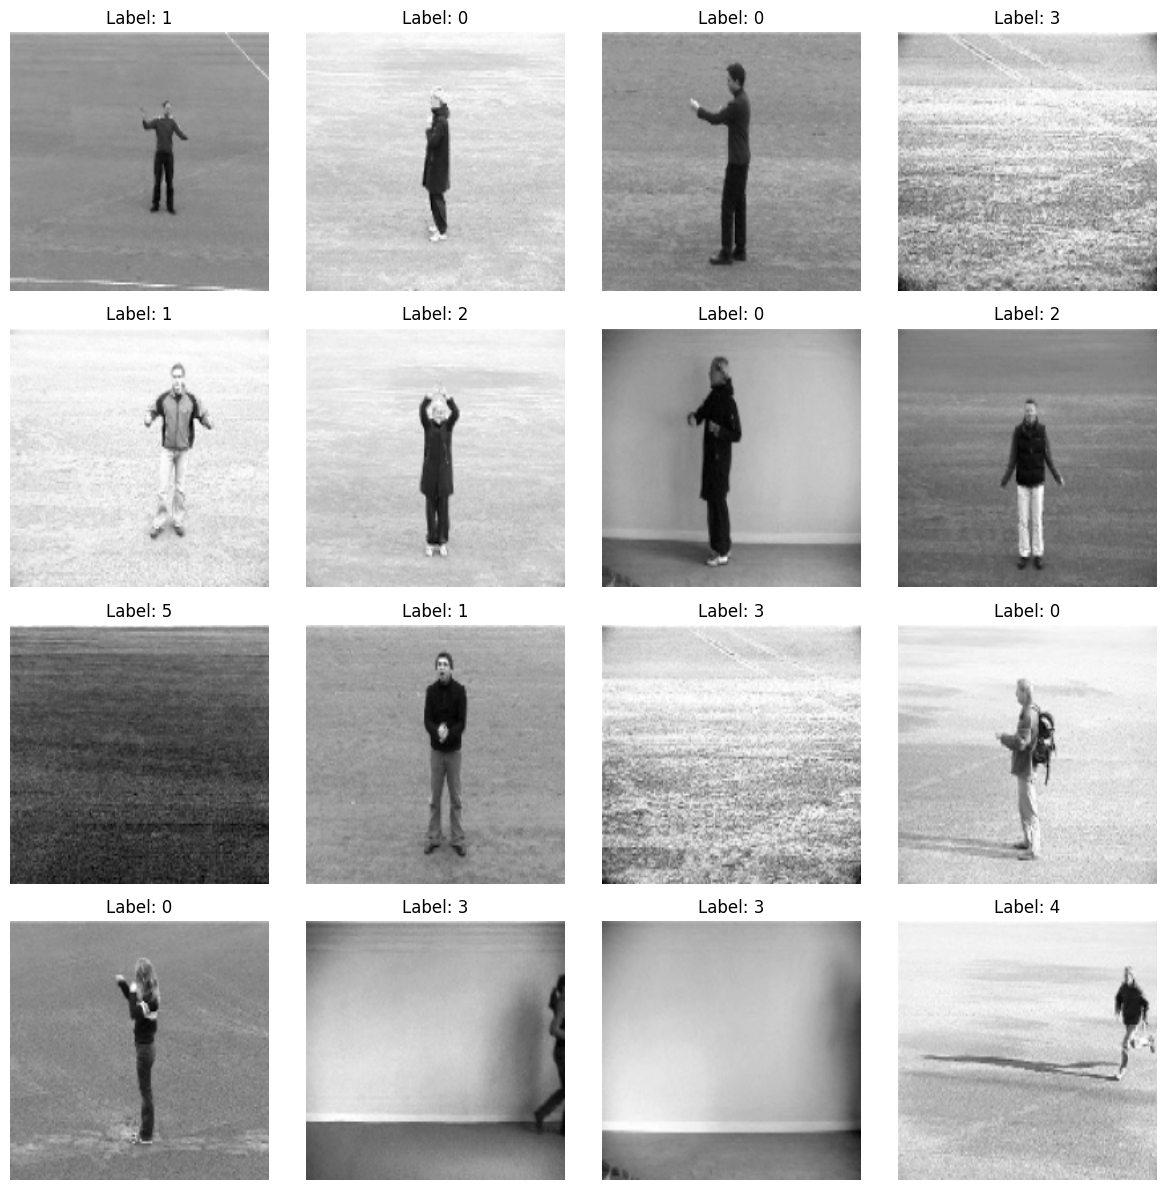

In [9]:
show_middle_frame_batch(train_loader)

These are inputs to our model which seems better than before hence maybe why there is an increase in accuracy. However, we still see some inputs without subjects in the frame. Instead we have the scene being fed, this is a bit problematic as we don't want our model to associate the scenes with the labels but rather the subject+action with the label. 

Let's now try using multiple frames for each video and see whether that leads to an improvement in our model's performance. The idea is hopefully by using multiple frames for each video, we successfully capture the temporal and spatial information embedded in the video. 

In [1]:
from torchvision import transforms
video_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # single-channel normalization
])


In [2]:
from utils.data_setup import VideoDataset_3
from torch.utils.data import DataLoader

train_dir = "Data/KTH_Actions/train"
test_dir = "Data/KTH_Actions/test"

train_dataset = VideoDataset_3(train_dir, transform=video_transform)
test_dataset = VideoDataset_3(test_dir, transform=video_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

In [5]:
import torch
from torch import nn
from torchvision import models as M
from helper_functions import set_seeds

model = M.efficientnet_b0(weights=M.EfficientNet_B0_Weights.DEFAULT)

# Modify first conv layer to accept grayscale input (1 channel)
old_conv = model.features[0][0]
model.features[0][0] = nn.Conv2d(
    in_channels=1,
    out_channels=old_conv.out_channels,
    kernel_size=old_conv.kernel_size,
    stride=old_conv.stride,
    padding=old_conv.padding,
    bias=old_conv.bias
)
with torch.no_grad():
    model.features[0][0].weight = nn.Parameter(old_conv.weight.mean(dim=1, keepdim=True))

# ===============================
#  Unfreeze last few feature blocks for fine-tuning
# ===============================
for param in model.features.parameters():
    param.requires_grad = False

for param in model.features[-3:].parameters():  # last 3 EfficientNet blocks
    param.requires_grad = True

# ===============================
# Replace classifier head
# ===============================
num_classes = len(train_dataset.classes)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(1280, num_classes)
)

model = model.to(device)

In [6]:
import torch
from torch import nn
from utils.engine import train_2
from utils.engine import set_seeds

set_seeds()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

resuls  = train_2(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device=device
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 1.6354, Train Acc: 0.3766 | Test Loss: 1.7274, Test Acc: 0.2768
Epoch 2 | Train Loss: 1.4940, Train Acc: 0.5484 | Test Loss: 1.4640, Test Acc: 0.6161
Epoch 3 | Train Loss: 1.4180, Train Acc: 0.6786 | Test Loss: 1.3981, Test Acc: 0.7232
Epoch 4 | Train Loss: 1.3999, Train Acc: 0.7259 | Test Loss: 1.4137, Test Acc: 0.6652
Epoch 5 | Train Loss: 1.3664, Train Acc: 0.7201 | Test Loss: 1.3898, Test Acc: 0.6875
Epoch 6 | Train Loss: 1.3615, Train Acc: 0.7368 | Test Loss: 1.4172, Test Acc: 0.6830
Epoch 7 | Train Loss: 1.3533, Train Acc: 0.7573 | Test Loss: 1.3575, Test Acc: 0.7321
Epoch 8 | Train Loss: 1.3371, Train Acc: 0.7675 | Test Loss: 1.3907, Test Acc: 0.6741
Epoch 9 | Train Loss: 1.3304, Train Acc: 0.7675 | Test Loss: 1.3707, Test Acc: 0.6920
Epoch 10 | Train Loss: 1.3311, Train Acc: 0.7491 | Test Loss: 1.3325, Test Acc: 0.7679


So, by fine-tuning the model and passing in more frames and aggregating the probabilites of the frames in the video using softmax we, end up with ~75% accuracy. Not bad considering the size of the model but not good.  

In [ ]:
## Code to save the model 
# all the functions in going modular are taken from the 'learnpytorch.io/' course/site
from going_modular import utils
model_path = Path('model')
model_path.mkdir(parents=True,exist_ok=True)
utils.save_model(model=model,target_dir=model_path,model_name='Your_model_name_placeholder.pth')

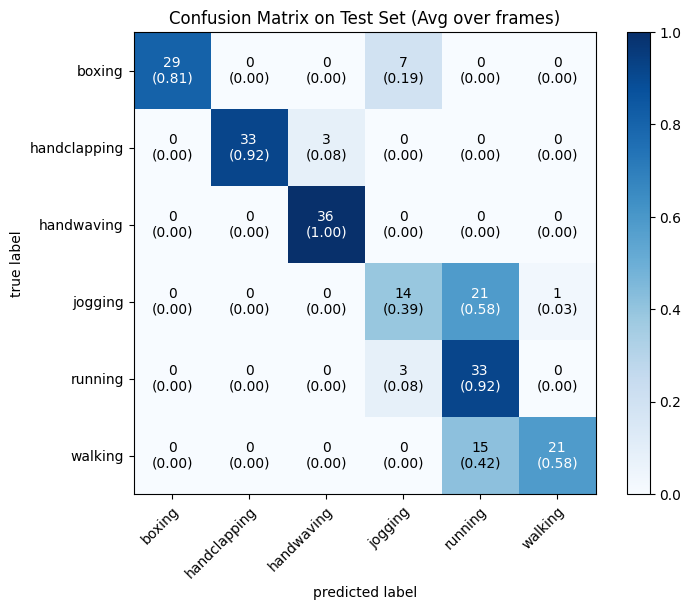

In [7]:
import torch
from torchmetrics.classification import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Ensure model is in eval mode
model.eval()

# Collect all predictions and labels
all_preds = []
all_labels = []

with torch.inference_mode():
    for X, y in test_loader:
        # X shape: [B, T, C, H, W]
        B, T, C, H, W = X.shape

        # Flatten frames into batch for prediction
        X_flat = X.view(B * T, C, H, W).to(device)

        # Get frame-level logits
        frame_logits = model(X_flat)  # [B*T, num_classes]

        # Reshape back to [B, T, num_classes]
        frame_logits = frame_logits.view(B, T, -1)

        # Convert to probabilities
        frame_probs = F.softmax(frame_logits, dim=-1)

        # Average probabilities over frames
        avg_probs = frame_probs.mean(dim=1)  # [B, num_classes]

        # Predicted class per video
        preds = avg_probs.argmax(dim=1)

        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

# Concatenate all predictions and labels
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# Compute confusion matrix
num_classes = len(train_dataset.classes)
confmat = ConfusionMatrix(task="multiclass", num_classes=num_classes)
cm = confmat(all_preds, all_labels).numpy()

# Plot using mlxtend
fig, ax = plot_confusion_matrix(
    conf_mat=cm,
    class_names=train_dataset.classes,
    figsize=(8, 6),
    show_normed=True,
    colorbar=True
)

plt.title("Confusion Matrix on Test Set (Avg over frames)")
plt.show()


The largest source of error for our model was for actions that seem somewhat similar with slight variations especially when you consider the input being still images. The hardest classes to distinguish would probably be between walking, running, jogging which is reflected in the Confusion matrix pictured above. The other overlap or rather suprising misclassification we see is between jogging and boxing. Which sort of makes sense as in boxing you tend to always move your feet using some sort of footwork which if looked at from a still image may mimic elements of jogging.



In [9]:
import matplotlib.pyplot as plt
import torch

def visualize_flattened_frames(X, num_frames=4):
    """
    Visualizes the first few frames of a flattened video batch X_flat = X.view(B*T, C, H, W).

    Args:
        X: Tensor of shape [B, T, C, H, W]
        num_frames: how many frames to display (from the start of the flattened batch)
    """
    B, T, C, H, W = X.shape
    # Flatten frames
    X_flat = X.view(B * T, C, H, W)

    # Convert to CPU & numpy
    X_flat_np = X_flat.cpu().numpy()

    # Determine how many frames to actually show
    num_frames = min(num_frames, X_flat_np.shape[0])

    fig, axs = plt.subplots(1, num_frames, figsize=(4 * num_frames, 4))
    if num_frames == 1:
        axs = [axs]  # Make iterable

    for i in range(num_frames):
        frame = X_flat_np[i]
        # If grayscale
        if frame.shape[0] == 1:
            frame = frame.squeeze(0)
            axs[i].imshow(frame, cmap='gray')
        else:
            # Convert C,H,W -> H,W,C for RGB
            frame = frame.transpose(1, 2, 0)
            axs[i].imshow(frame)
        axs[i].set_title(f"Frame {i+1}")
        axs[i].axis('off')

    plt.show()


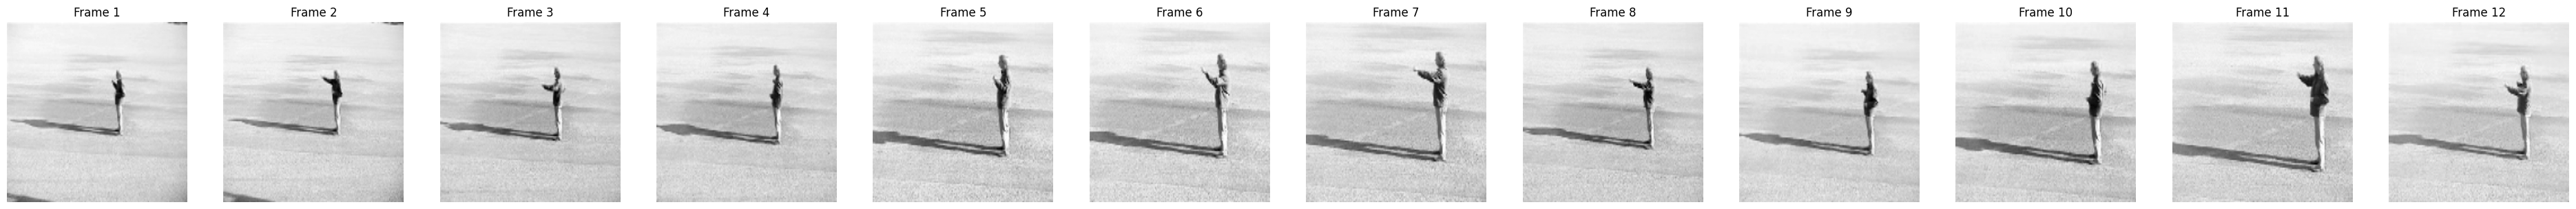

In [11]:
# Suppose you have a batch X from DataLoader
X, y = next(iter(train_loader))  # X: [B, T, C, H, W]
visualize_flattened_frames(X, num_frames=12)


This shows a typical batch of inputs for one of the actions possibly handclapping. In here we see how the temporal information from the video is split into multiple frames and then fed into the model.

### EFFICIENT_NET BACKBONE WITH TEMPORAL GRU 

This is the final strategy that will be deployed in this notebook. Though at the end further improvements/ideas will be suggested but not followed through. This is a somewhat hybrid architecture where we use the efficient_net_B0 as the backbone and temporal GRU network as the head and learnable network. The input strategy remains the same as the previous iteration.

In [ ]:
from torch import nn
import torchvision.models as M
# ---------------------------
# 2️⃣ EfficientNet-B0 Backbone (grayscale)
# ---------------------------
from torch import nn
import torchvision.models as M
import torch


class EfficientNetBackbone(nn.Module):
    def __init__(self, pretrained=True, freeze=True, load_from=None):
    
        super().__init__()

        # Load vanilla EfficientNet-B0
        model = M.efficientnet_b0(
            weights=M.EfficientNet_B0_Weights.DEFAULT if pretrained and load_from is None else None
        )

        # Patch first conv layer for grayscale input
        old_conv = model.features[0][0]
        new_conv = nn.Conv2d(
            in_channels=1,
            out_channels=old_conv.out_channels,
            kernel_size=old_conv.kernel_size,
            stride=old_conv.stride,
            padding=old_conv.padding,
            bias=old_conv.bias
        )
        with torch.no_grad():
            new_conv.weight = nn.Parameter(old_conv.weight.mean(dim=1, keepdim=True))

        model.features[0][0] = new_conv

        # ✅ Load from .pth if provided
        if load_from is not None:
            print(f"Loading pretrained EfficientNet backbone from: {load_from}")
            state = torch.load(load_from, map_location="cpu")

            # Remove classifier layer weights
            state = {k: v for k, v in state.items() if k.startswith("features")}

            # Load backbone-only weights (ignore classifier)
            model.load_state_dict(state, strict=False)

        # Freeze if requested
        if freeze:
            for p in model.features.parameters():
                p.requires_grad = False

        self.backbone = model.features
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.out_dim = 1280

    def forward(self, frames):
        """
        frames: [B, T, 1, 224, 224]
        returns: [B, T, 1280]
        """
        B, T, C, H, W = frames.shape
        x = frames.view(B * T, C, H, W)
        feats = self.backbone(x)
        pooled = self.pool(feats).view(B * T, -1)
        e = pooled.view(B, T, -1)
        return e



# ---------------------------
# 3️⃣ Temporal Aggregator (GRU)
# ---------------------------
class TemporalGRU(nn.Module):
    def __init__(self, emb_dim=1280, hidden_dim=512, n_classes=6):
        super().__init__()
        self.gru = nn.GRU(emb_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, n_classes)
        )

    def forward(self, x):
        out, _ = self.gru(x)          # [B, T, 2*hidden_dim]
        out = out[:, -1, :]            # last timestep
        logits = self.classifier(out)
        return logits

In [2]:
import torch
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

video_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])



In [5]:
from utils.data_setup import VideoDataset_4
from torch.utils.data import DataLoader
from utils.engine import train_model_3

train_dataset = VideoDataset_4("Data/KTH_Actions/train", transform=video_transform)
test_dataset = VideoDataset_4("Data/KTH_Actions/test", transform=video_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

backbone = EfficientNetBackbone(pretrained=True, freeze=True, load_from='model/EfficientNet_B0_10epochs_1FPS_fine_tuned.pth').to(device)
temporal_model = TemporalGRU(emb_dim=1280, hidden_dim=512, n_classes=len(train_dataset.classes)).to(device)  # emb_dim=backbone.out_dim for simplicity

optimizer = torch.optim.Adam(temporal_model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

# Train
results = train_model_3(backbone, temporal_model, train_loader, test_loader, optimizer, loss_fn, device, epochs=5)


Loading pretrained EfficientNet backbone from: model/EfficientNet_B0_10epochs_1FPS_fine_tuned.pth


Epochs:   0%|          | 0/5 [00:00<?, ?epoch/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Testing :   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Testing :   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Testing :   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Testing :   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Testing :   0%|          | 0/14 [00:00<?, ?it/s]

From the looks of it we ran into an overfitting problem. It seems our model started to memorize the input data rather generalize well to the whole dataset. 

In [8]:
from pathlib import Path
from going_modular import utils
model_path = Path('model')
model_path.mkdir(parents=True,exist_ok=True)
utils.save_model(model=temporal_model,target_dir=model_path,model_name='EfficientNetBackBone_B0_finetuned_TemporalGRU_5epochs.pth')

[INFO] Saving model to: model\EfficientNetBackBone_B0_finetuned_TemporalGRU_5epochs.pth


In [9]:
import matplotlib.pyplot as plt
import torch
from torchvision.transforms.functional import to_pil_image
import cv2

# ---------------------------
# 1️⃣ Plot training/testing results
# ---------------------------
def plot_training_results(results):
    epochs = range(1, len(results['train_loss']) + 1)

    plt.figure(figsize=(12,5))
    # Loss
    plt.subplot(1,2,1)
    plt.plot(epochs, results['train_loss'], 'b-o', label='Train Loss')
    plt.plot(epochs, results['test_loss'], 'r-o', label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, results['train_acc'], 'b-o', label='Train Acc')
    plt.plot(epochs, results['test_acc'], 'r-o', label='Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.grid(True)

    plt.show()


In [10]:
import matplotlib.pyplot as plt
import torch

def visualize_batch(batch, n_samples=4, figsize_per_frame=2):
    """
    Visualizes a batch of video frames in a grid: [samples x timesteps]

    Args:
        batch: dict with keys:
            - 'frames': [B, T, C, H, W]
            - 'labels': [B]
        n_samples: number of videos to show
        figsize_per_frame: size multiplier for each subplot cell
    """
    frames = batch['frames']          # [B, T, C, H, W]
    labels = batch['labels']          # [B]
    B, T, C, H, W = frames.shape

    n_samples = min(B, n_samples)

    # Create grid (handling the case T or n_samples == 1)
    fig, axes = plt.subplots(
        n_samples, T,
        figsize=(T * figsize_per_frame, n_samples * figsize_per_frame),
        squeeze=False  # always 2D array for safety
    )

    for b in range(n_samples):
        for t in range(T):
            img = frames[b, t]

            # If grayscale
            if C == 1:
                img = img.squeeze(0)
                axes[b, t].imshow(img.cpu(), cmap='gray')
            else:
                img = img.permute(1, 2, 0)  # CHW -> HWC
                axes[b, t].imshow(img.cpu())

            axes[b, t].axis("off")

            # Add labels on the left margin
            if t == 0:
                axes[b, t].set_ylabel(
                    f"Label: {labels[b].item()}",
                    fontsize=10
                )

    plt.tight_layout()
    plt.show()


In [19]:
import random
# ---------------------------
# 3️⃣ Predict a single video (robust version)
# ---------------------------
def predict_video(video_path, backbone, temporal_model, transform,
                  frames_per_clip=16, frame_skip=1, device='cuda'):
    """
    Returns:
        - predicted class index
        - frames tensor used [T, C, H, W]
    """

    # ---------------------------
    # 1. Load frames
    # ---------------------------
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames is None or total_frames == 0:
        raise ValueError(f"❗ Could not read video or video has 0 frames: {video_path}")

    frame_indices = list(range(0, total_frames, frame_skip))

    # If more frames than needed: sample
    if len(frame_indices) > frames_per_clip:
        frame_indices = sorted(random.sample(frame_indices, frames_per_clip))

    frames = []
    for i in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            continue

        # Convert to grayscale if needed
        if len(frame.shape) == 3 and frame.shape[2] > 1:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        frames.append(frame)

    cap.release()

    # ---------------------------
    # ✅ FIX: Handle empty frame list
    # ---------------------------
    if len(frames) == 0:
        raise ValueError(f"❗ No readable frames extracted from: {video_path}")

    # ---------------------------
    # ✅ Pad short videos
    # ---------------------------
    if len(frames) < frames_per_clip:
        last = frames[-1]
        frames.extend([last] * (frames_per_clip - len(frames)))

    # ---------------------------
    # ✅ If somehow longer (rare), uniformly re-sample
    # ---------------------------
    if len(frames) > frames_per_clip:
        idxs = np.linspace(0, len(frames)-1, frames_per_clip).astype(int)
        frames = [frames[i] for i in idxs]

    # ---------------------------
    # 2. Transform frames
    # ---------------------------
    processed_frames = []
    for f in frames:
        f = torch.from_numpy(f).unsqueeze(0).float() / 255.0

        # If user provided transform (expects PIL)
        if transform:
            from torchvision.transforms.functional import to_pil_image
            f = transform(to_pil_image(f))

        processed_frames.append(f)

    frames_tensor = torch.stack(processed_frames)  # [T, C, H, W]
    frames_tensor = frames_tensor.unsqueeze(0).to(device)  # [1, T, C, H, W]

    # ---------------------------
    # 3. Forward pass
    # ---------------------------
    with torch.no_grad():
        embeddings = backbone(frames_tensor)        # [1, T, 1280]
        logits = temporal_model(embeddings)         # [1, n_classes]
        probs = torch.softmax(logits, dim=-1)
        pred_class = probs.argmax(dim=-1).item()

    return pred_class, frames_tensor.squeeze(0).cpu()


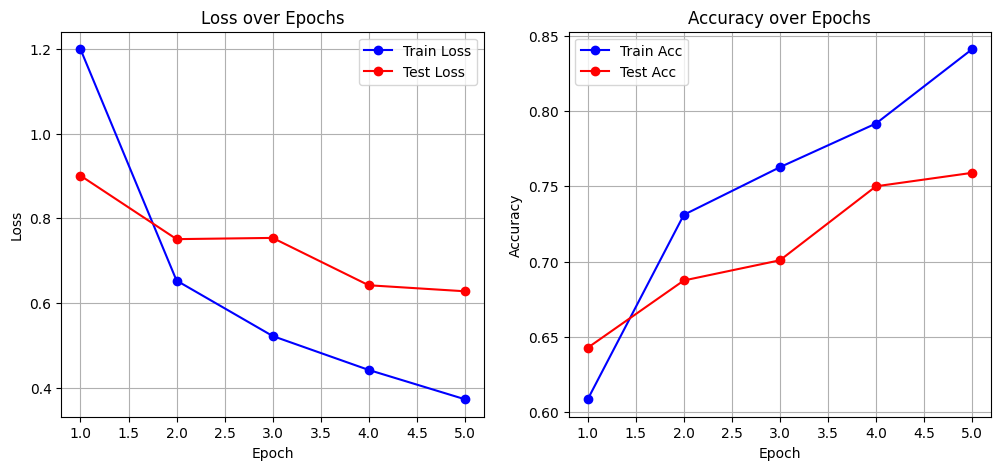

In [16]:
# 1️⃣ Plot training
plot_training_results(results)




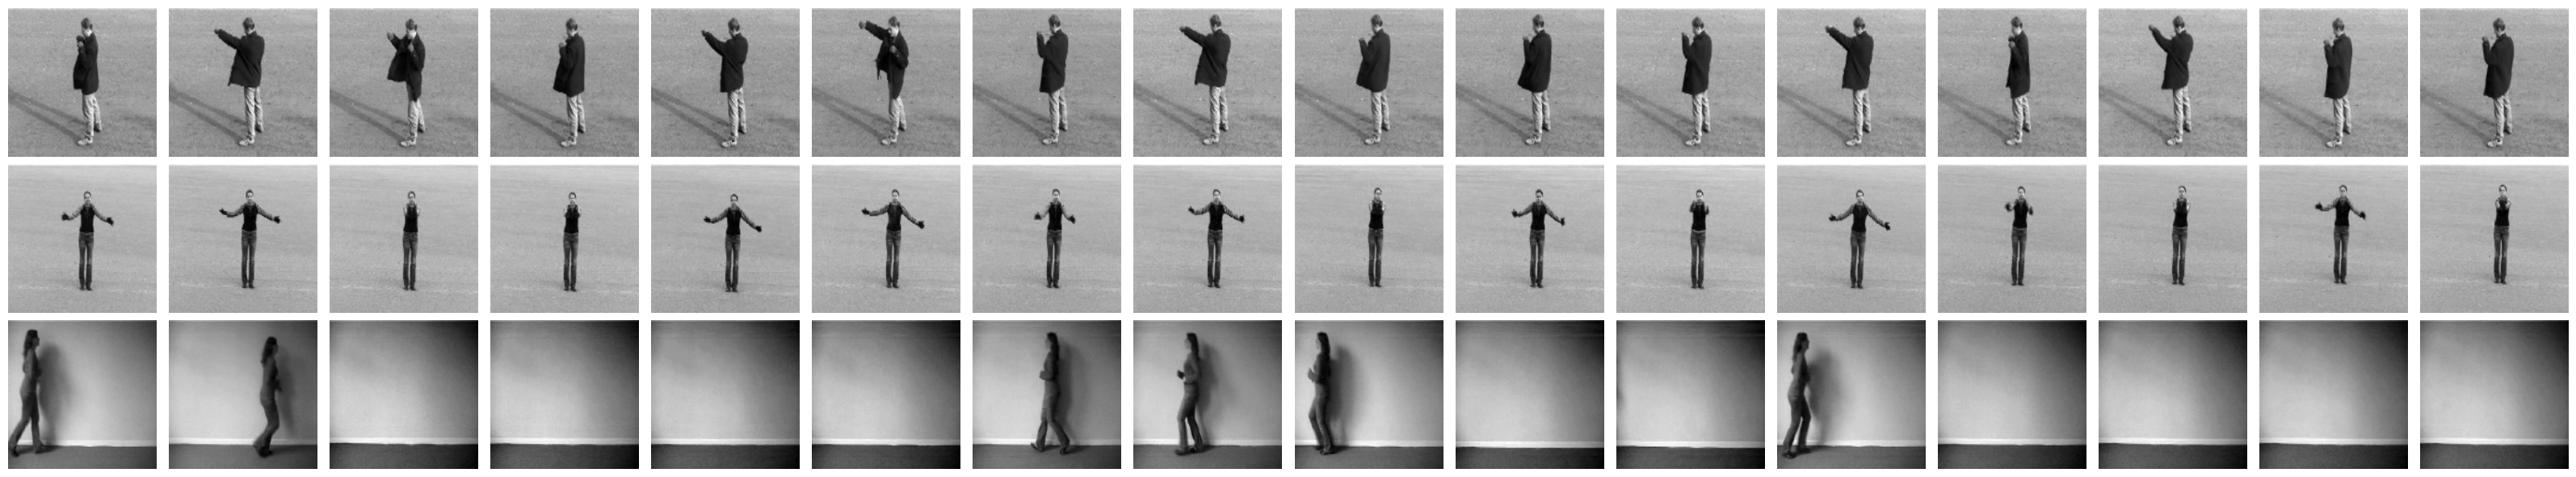

In [17]:
# 2️⃣ Visualize first batch
batch = next(iter(train_loader))
visualize_batch(batch, n_samples=3)



We still see that the problem of selecting poor frames still persists. For the first two instances we can somewhat say even from still frames that the first person is boxing and second person is clapping. However, when action involves the subject stepping away from the frame as is the case in walking, running, and jogging. The input contains a lot of frames without the subject in them. The problem lies with the fact that along with these frames the labels are also passed to the network, and the job of the model is then to decipher the actions from still frames without the subject. Which may be a possible explantion why we see such a stark contrast between the training and testing accuracy. Thus one possible reason may be the model trying to memorize these 'bad' scenes/frames to increase the accuracy and reduce the loss. 

In [24]:
# 3️⃣ Predict a video
video_path = "Data/KTH_Actions/test/Walking/person21_walking_d1_uncomp.avi"
pred_class, frames_used = predict_video(video_path, backbone, temporal_model, video_transform, device=device)
print("Predicted class:", train_dataset.classes[pred_class])



Predicted class: walking


In [25]:
def show_frames_grid(frames_used, cols=8, figsize=2):
    """
    frames_used: [T, C, H, W] tensor from predict_video
    cols: number of columns in grid
    figsize: size multiplier for each subplot cell
    """
    import math
    import matplotlib.pyplot as plt

    T = frames_used.shape[0]
    rows = math.ceil(T / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * figsize, rows * figsize), squeeze=False)

    for idx in range(rows * cols):
        r = idx // cols
        c = idx % cols

        ax = axes[r][c]

        if idx < T:
            f = frames_used[idx]   # [C, H, W]

            # Grayscale
            if f.shape[0] == 1:
                img = f.squeeze(0).cpu()
                ax.imshow(img, cmap='gray')
            else:
                img = f.permute(1, 2, 0).cpu()  # CHW -> HWC
                ax.imshow(img)

            ax.set_title(f"Frame {idx+1}", fontsize=8)
        else:
            ax.axis('off')

        ax.axis('off')

    plt.tight_layout()
    plt.show()

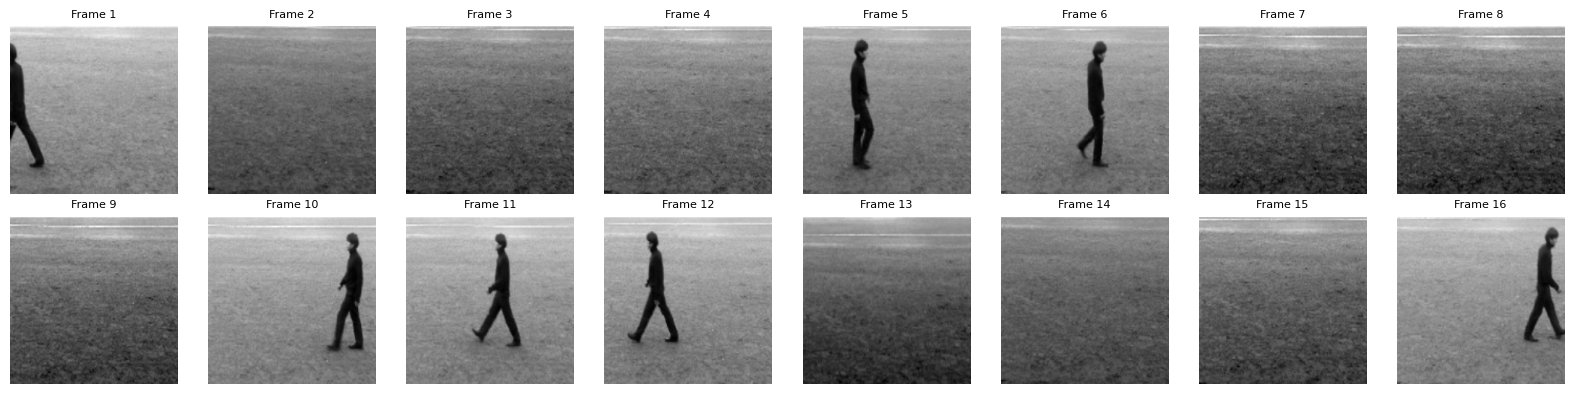

In [26]:
show_frames_grid(frames_used, cols=8)

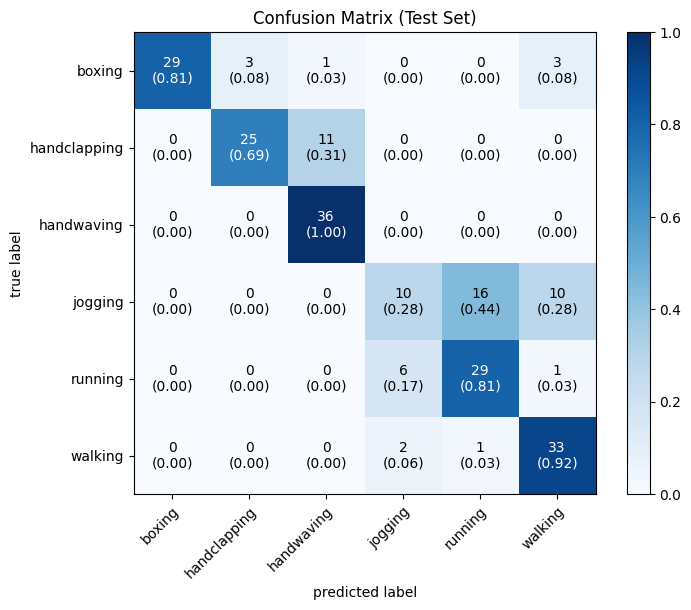

In [38]:
import torch
from torchmetrics.classification import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import torch.nn.functional as F


existing_classes = sorted(list(set(all_labels.tolist())))
cm = cm[existing_classes][:, existing_classes]  # keep only existing rows/cols
class_names = [train_dataset.classes[i] for i in existing_classes]


backbone.eval()
temporal_model.eval()
all_preds = []
all_labels = []

with torch.inference_mode():
    for batch in test_loader:
        X = batch["frames"].to(device)  # [B, T, C, H, W]
        y = batch["labels"].to(device)  # [B]

        B, T, C, H, W = X.shape
        X_flat = X.view(B*T, C, H, W)

        # Backbone → embeddings
        embeddings = backbone(X)
        logits = temporal_model(embeddings)  # [B, num_classes]

        all_preds.append(logits.argmax(dim=1).cpu())
        all_labels.append(y.cpu())

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# Compute confusion matrix
num_classes = len(train_dataset.classes)
confmat = ConfusionMatrix(task="multiclass", num_classes=num_classes)
cm = confmat(all_preds, all_labels).numpy()

# Plot
fig, ax = plot_confusion_matrix(
    conf_mat=cm,
    class_names=train_dataset.classes,
    figsize=(8, 6),
    show_normed=True,
    colorbar=True
)
plt.title("Confusion Matrix (Test Set)")
plt.show()

In [40]:
# ---------------------------
# Predict a video with frame-level probabilities
# ---------------------------
def predict_video_with_frame_probs(
    video_path,
    backbone,
    temporal_model,
    transform,
    frames_per_clip=16,
    frame_skip=1,
    device='cuda'
):
    """
    Returns:
        - predicted class (int)
        - frames tensor used [T, C, H, W]
        - frame-level class probabilities [T, num_classes]
    """
    # Load frames
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = list(range(0, total_frames, frame_skip))

    if len(frame_indices) > frames_per_clip:
        frame_indices = sorted(random.sample(frame_indices, frames_per_clip))

    frames = []
    for i in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            continue
        if len(frame.shape) == 3 and frame.shape[2] > 1:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(frame)
    cap.release()

    while len(frames) < frames_per_clip:
        frames.append(frames[-1])

    # Transform frames
    processed_frames = []
    for f in frames:
        f = torch.from_numpy(f).unsqueeze(0).float()/255.0
        if transform:
            from torchvision.transforms.functional import to_pil_image
            f = transform(to_pil_image(f))
        processed_frames.append(f)

    frames_tensor = torch.stack(processed_frames)  # [T, C, H, W]
    frames_tensor_device = frames_tensor.unsqueeze(0).to(device)  # [1, T, C, H, W]

    # Forward pass
    with torch.no_grad():
        embeddings = backbone(frames_tensor_device)       # [1, T, emb_dim]
        logits = temporal_model(embeddings)              # [1, num_classes]

        # Frame-level logits via GRU outputs
        # This requires minor modification: temporal_model.gru outputs all timesteps
        # We'll assume temporal_model.gru is accessible and bidirectional
        temporal_model.eval()
        gru_out, _ = temporal_model.gru(embeddings)      # [1, T, 2*hidden_dim]
        frame_logits = temporal_model.classifier(gru_out)  # [1, T, num_classes]
        frame_probs = torch.softmax(frame_logits.squeeze(0), dim=-1)  # [T, num_classes]

        pred_class = logits.argmax(dim=-1).item()

    return pred_class, frames_tensor, frame_probs.cpu()


Predicted class: running
Predicted class: running


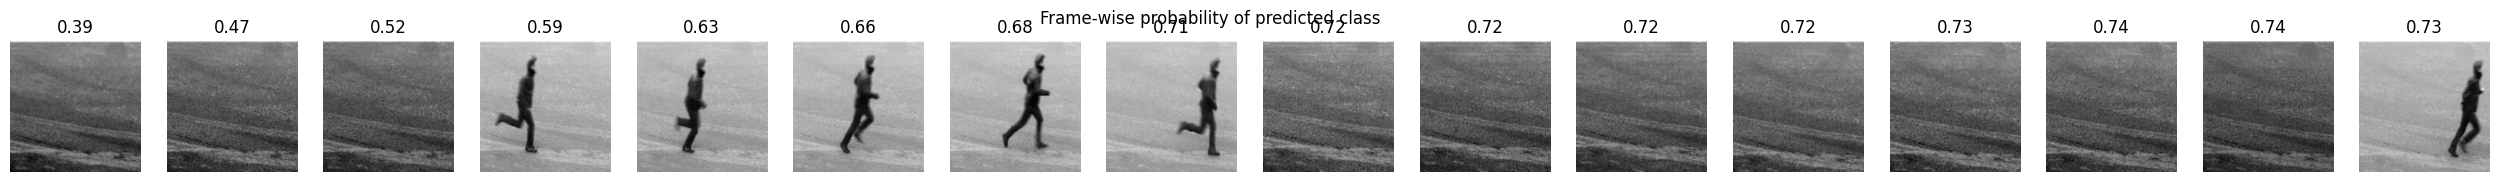

In [42]:
video_path = "Data/KTH_Actions/test/running/person24_running_d1_uncomp.avi"
pred_class, frames_used = predict_video(video_path, backbone, temporal_model, video_transform, device=device)
print("Predicted class:", train_dataset.classes[pred_class])


pred_class, frames_used, frame_probs = predict_video_with_frame_probs(
    video_path, backbone, temporal_model, video_transform, device=device
)

print("Predicted class:", train_dataset.classes[pred_class])

# Visualize frames with max probability per frame
import matplotlib.pyplot as plt
T = frames_used.shape[0]
fig, axes = plt.subplots(1, T, figsize=(T*2,2))
for t in range(T):
    img = frames_used[t].squeeze(0)
    axes[t].imshow(img, cmap='gray')
    axes[t].axis('off')
    prob = frame_probs[t, pred_class].item()
    axes[t].set_title(f"{prob:.2f}")
plt.suptitle("Frame-wise probability of predicted class")
plt.show()


In the above example we see that a lot of the selected frames do not contain any human/motion/shadow yet still some frames have significant probabilities attached to them. 

From this we can gather that perhaps what the model memorized retained the scenes in which the subjects were running/wlaking/jogging. Although not shown in the example above but of five videos of jogging only one was able to be identified correctly. Because if you think about it, it is very hard to discern from still frames whther a person is walking or jogging only with temporal data that is by observing changes across multiple frames can we say with a certain level of certainty that the person was joggging. 

So, to tackle this I propose:

- Having a YOLO/Obj detection model running on the video to first and foremost return frames with subjects (human) in them. Then a step further would be to take the difference between to subsequent frames to detect motion/action between them and if the diff. crosess a certain threshold then take both frames or else discard the posterior frame and keep the former one and repeat the same thing with the next frame in the sequence. This however poses its own problems:
    - First we would be introduing new parameters that we would neeed to optimize such as how long of a sequence do we want to keep? 
    - How many frames per second do we take ?
    - The addded complexity/overhead of an obj detection model just to detect the subject in the frame. 
    - The diff. method will work well if the scene remains static and the diff. we get is only from the movement of the subject through time, however, this quickly falls apart if the scene also changes with time. 
    - We also get variable number of frames per video so, we need to standardize the number of frames per video that can be taken. 
- The other thing is also similar to the idea above but we just remove the obj. detection algorithm compute the visual diff. between frames and if it crosses a certain threshold then take the frames otherwise dicard it. The problems of the diff. method are shared between the first and second ideas however, it is a much more detrimental problem for this idea.  


This is where I stop iterating over this project in this notebook. This was purely an exercise to see whether a 'small' model could be trained/adapted to handle temporal video data and yield results that might seem ok relative to the model size. However, this is where I stop as I feel each iteration gets a bit more complex than the previous with diminishing returns. I do wish good fortune to whoever wants to continue the project with better and more thought-out iterations. 